Train size is 10 and test size is 10. 4x4.
Train time is 0.3 minutes.
This training size will be skipped because the reward couldn't be reached.
Test time is 4.2 minutes.
Train size is 10 and test size is 10. 8x8.
Train time is 1.2 minutes.
This training size will be skipped because the reward couldn't be reached.
Test time is 4.2 minutes.
Train size is 20 and test size is 10. 4x4.
Train time is 0.6 minutes.
This training size will be skipped because the reward couldn't be reached.
Test time is 4.2 minutes.
Train size is 20 and test size is 10. 8x8.
Train time is 2.7 minutes.
This training size will be skipped because the reward couldn't be reached.
Test time is 4.2 minutes.
Train size is 50 and test size is 10. 4x4.
Train time is 1.6 minutes.
First episode where the reward equals 1 is the 25th episode.
Training size is 50 and the reward could be reached in 1 of them.
The training is 1 / 50 succesful.
Test time is 4.2 minutes.
Train size is 50 and test size is 10. 8x8.
Train time is 7.

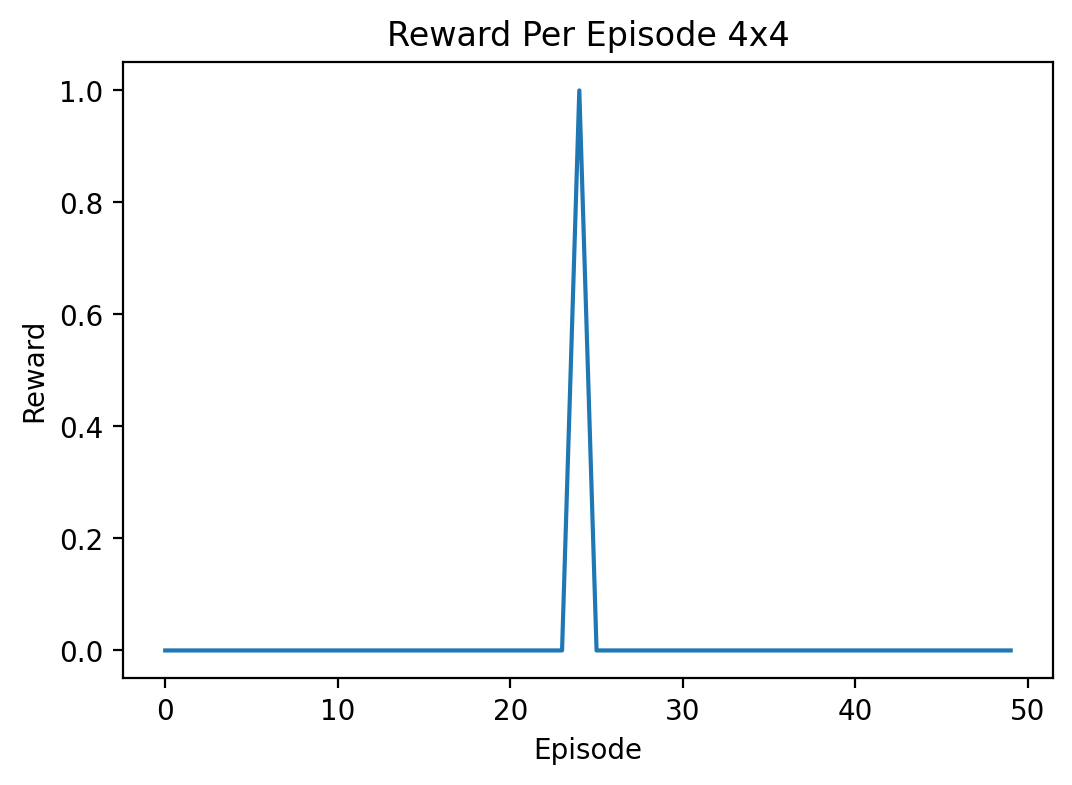

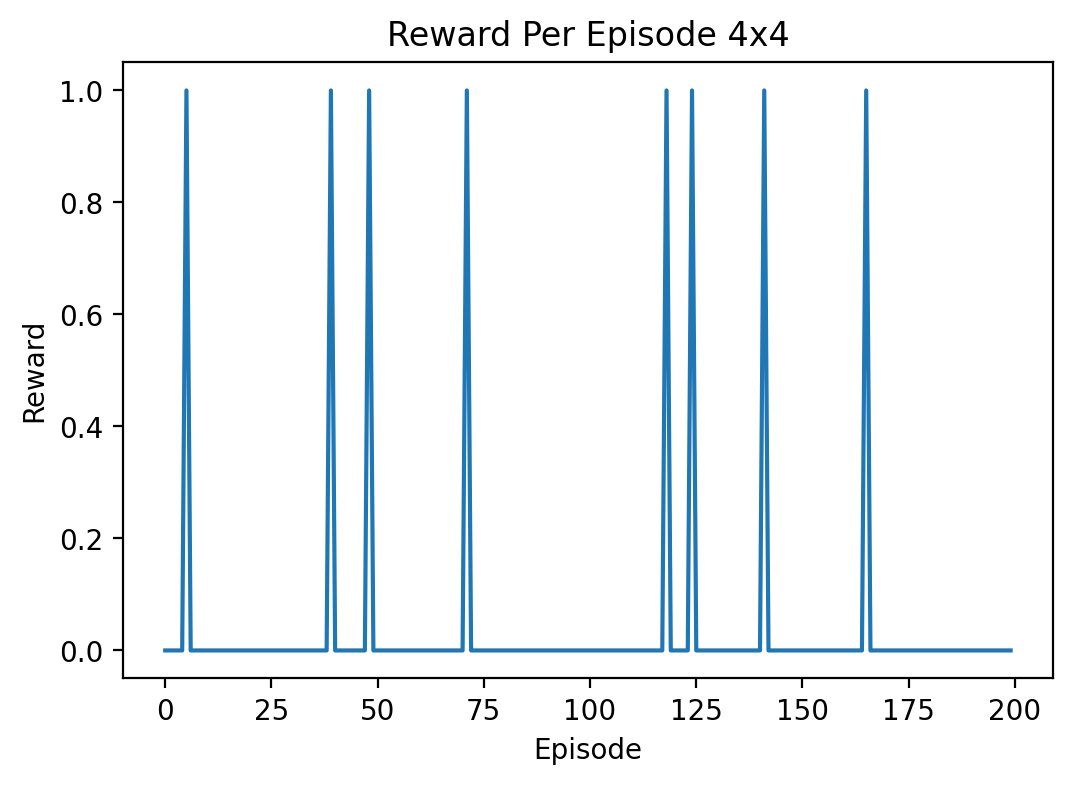

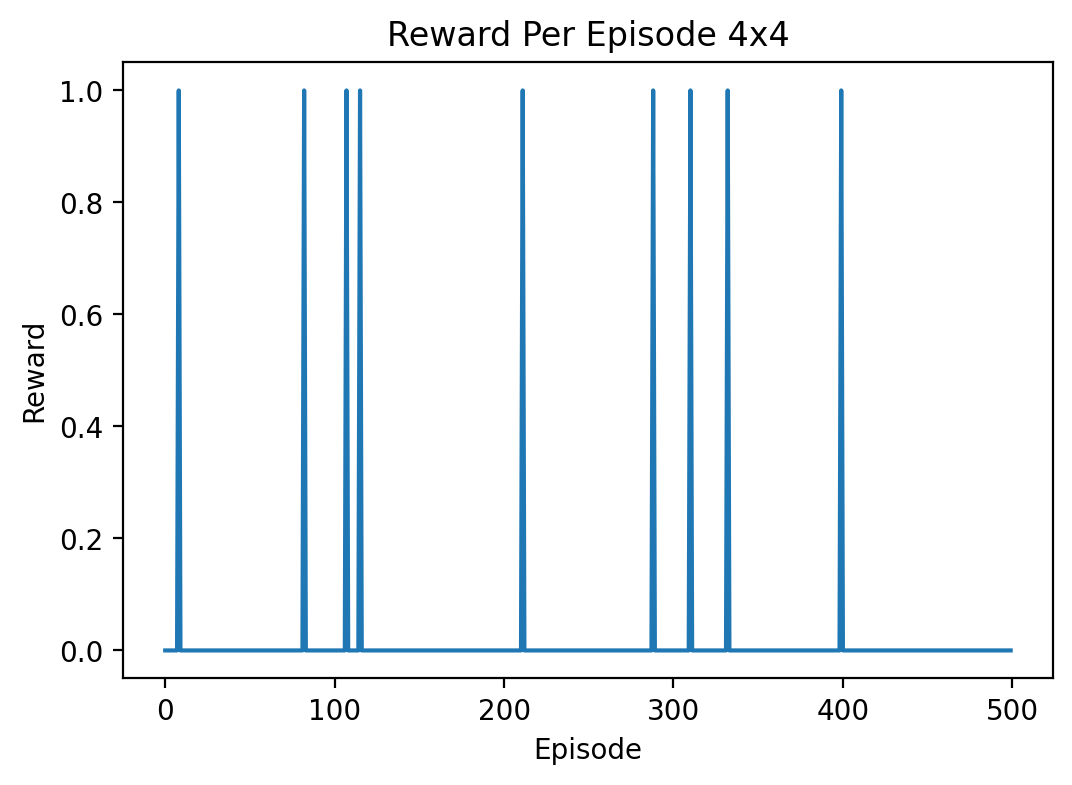

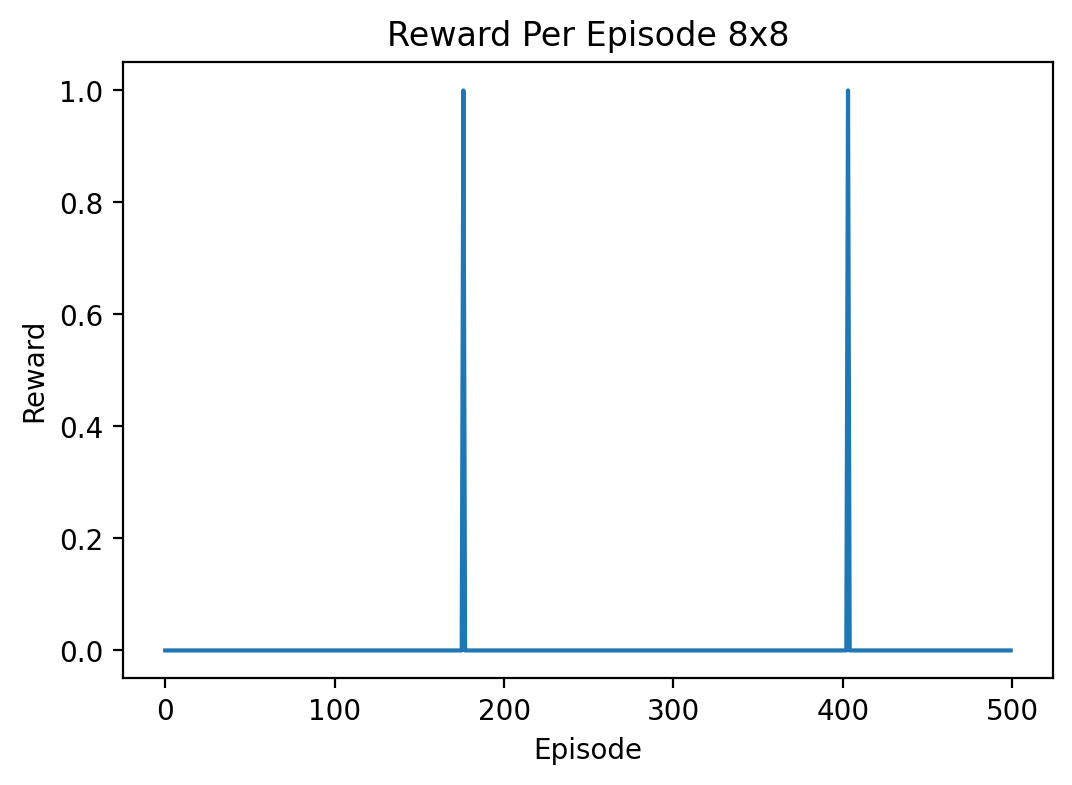

In [6]:
# İlk olarak gerekli kütüphaneleri import ediyoruz.
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
from timeit import default_timer as timer 


class DeepQNetworkModel(nn.Module):
    # Modeli initialize edip network layer tanımı yaparken alacağı değerleri belirledim. Örn: in_features...
    def __init__(self, in_features, hidden_layers, out_features):
        super().__init__()
        
        # Sonrasında input ve output layerlarını tanımladım ve almaları gereken parametreleri girdim.
        self.first_layer = nn.Linear(in_features, hidden_layers)
        
        self.second_layer = nn.Linear(hidden_layers, out_features)


    # Forward fonksiyonunda ilk olarak elimizdeki veri lineer olmadığı için ReLu Activation uyguladım ve outputu return ettim.
    def forward(self, x):
        x = F.relu(self.first_layer(x))
        
        x = self.second_layer(x)
        
        return x


# Önceki aksiyonları takip edebilmemiz için bir replay buffer oluşturuyoruz ve bu sonuçları bir araya toplama işlemini deque ile yapıyoruz.
class ReplayBuffer():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    # Her bir transition olduğunda bunu memorye ekliyoruz.
    def append(self, transition):
        self.memory.append(transition)

    # Agent bazı durumlarda random bir karar verebilsin diye random sample alıyoruz.
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)
    

class DeepQLearning():
    # İleride kullanacağımız bazı parametreleri tanımlıyoruz.
    BATCH_SIZE = 32 # Replay bufferda aldığımız training verisinin büyüklüğü.
    
    BUFFER_SIZE = 1000 # Replay bufferın büyüklüğü.
    
    LR = 0.001 # Sistemin öğrenme oranı.
    
    DISCOUNT = 0.9 # Kullanacğımız discount oranı    
    
    SYNC_STEPS = 10 # Policy ve target networkler arasında dengeyi sağlayacak ve onları daha efektip olarak kullanabileceğiz.

    loss_function = nn.MSELoss() # Mean squared error kullanarak modelimizin başarısını ölçeceğiz.
    
    optimizer = None # Modeli optimize etmek için kullanacağız. Şimdilik None olacak, ileride değişecek.
    
    actions = ["Left", "Down", "Right", "Up"] # 0, 1, 2, 3  Sol, Aşağı, Sağ, Aşağı

    start_time = timer()
    end_time = timer()  

    # Training için bir fonksiyon oluşturuyoruz ve parametrelerini belirliyoruz.
    def train_4x4(self, episodes, is_slippery):
        torch.manual_seed(42)
        
        train_time_start_4x4 = timer()
        
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=False, render_mode='human')
        
        env.reset()
        
        env.render()
    
        number_of_states = env.observation_space.n # State sayısı
        
        number_of_actions = env.action_space.n # Action sayısı

        # En yukarıda bahsedilen epsilon greedy uygulamasının bir örneğini kullanacağız.
        EPS = 1 # EPS modelin ne kadar rastgele ilerleyeceğini belirleyecek. EPS = 1 ise %100 random anlamına geliyor.
    
        memory = ReplayBuffer(self.BUFFER_SIZE)

        # Modeli train etmek için policy ve test etmek için de bir target network oluşturuyoruz.
        policy_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions)
        
        target_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions)
    
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Optimizerı belirledim.
        self.optimizer = torch.optim.SGD(policy_dqn.parameters(), lr=self.LR)

        # Episode başına reward takibi yapmak için.
        rewards_per_episode = np.zeros(episodes)

        # EPS değerini takip etmek için.
        epsilon_history = []

        # Yukarıda bahsettiğimiz policy ve target networkleri takip etmek için kullanacağız.
        step_count = 0

        for i in range(episodes):
            state = env.reset()[0]  # İlk state için initalize ediyoruz.
            terminated = False      # Agent kuyuya düşerse veya hedefe oluşursa True olacak.
            truncated = False       # Agent 200'den fazla action alırsa True olacak. 

            # Agent kuyuya düştü mü, hedefe ulaştı mı ya da 200 action aldı mı sorularının takibini yapıyoruz.
            while not terminated and not truncated:
                # EPS değerine göre random bir action seçiyoruz.
                if random.random() < EPS:
                    action = env.action_space.sample()
                
                else:
                    # En işe yarar action seçiliyor.        
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)).argmax().item()

                # Seçtiğimiz action uygulanıyor.
                new_state, reward, terminated, truncated, _ = env.step(action)
                
                # Buffer'a action kaydediliyor.
                memory.append((state, action, new_state, reward, terminated)) 
                
                # Sıradaki state geçişi.
                state = new_state
                
                # Step counta da 1 ekliyoruz.
                step_count += 1
            
            # Reward 1 ise değerini 1 olarak giriyoruz.
            if reward == 1:
                rewards_per_episode[i] = 1
            
            # Yeterince training yaptık mı ve en az 1 reward toplayabildik mi diye bakıyoruz.
            if len(memory) > self.BATCH_SIZE and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.BATCH_SIZE)
            
                # Optimize etme işlemi. 
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # EPS değerini değiştirmeye başlıyoruz ki sonuçlarımız da farklı olsun.
                EPS = max(EPS - 1 / episodes, 0)

                epsilon_history.append(EPS)

                # Belli bir süre sonra policy network değerlerini aynı şekilde target networke de veriyoruz.
                if step_count > self.SYNC_STEPS:
                    target_dqn.load_state_dict(policy_dqn.state_dict())

                    step_count = 0
        
        # Sistemi kapatıyoruz.
        env.close()
        train_time_end_4x4 = timer()
        train_time_minutes_4x4 = (train_time_end_4x4 - train_time_start_4x4) / 60
        print(f"Train time is {train_time_minutes_4x4:.1f} minutes.")

        try:
            reward_is_1 = rewards_per_episode.tolist().index(1)
            print(f"First episode where the reward equals 1 is the {reward_is_1 + 1}th episode.")

            total_reward_is_1 = [reward for reward, x in enumerate(rewards_per_episode) if x == 1]
            print(f"Training size is {size} and the reward could be reached in {len(total_reward_is_1)} of them.")

            print(f"The training is {len(total_reward_is_1)} / {size} succesful.")
            
            plt.figure(dpi=200, figsize=(6, 4))
            plt.title("Reward Per Episode 4x4")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.plot(rewards_per_episode)

        except ValueError:
            print("This training size will be skipped because the reward couldn't be reached.")
            pass
        
        sum_rewards = np.zeros(episodes)
        
    # Optimizasyon(yukarıda kullandığımız).
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        # Inputları alıyoryuz ve q değerlerini saklamak için 2 boş liste oluşturuyoruz.
        number_of_states = policy_dqn.first_layer.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                # Agent ya hedefe ulaştı ya da kuyuya düştü. Sırasıyla reward 1 ve 0.
                # Terminated True ise target q reward olarak belirlenmeli.
                target = torch.FloatTensor([reward])
            else:
                # Target q değerini hesaplamak için formülünü kullanıyoruz.
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.DISCOUNT * target_dqn(self.state_to_tensor_represantation(state=new_state, number_of_states=number_of_states)).max())

            # Elimizdeki q değerleri.
            current_q = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states))
            current_q_list.append(current_q)

            # Hedef q değerleri
            target_q = target_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)) 
            
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Loss function kullanarak kaybımızı ölçüyoruz.
        loss = self.loss_function(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimizasyon
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    # Elimizdeki statei tensor olarak kullanabilmemiz için. 16 state var ve bunlardan hangisi mevcut state ise onun değeri 1 ve geri kalanlar 0 olacak.
    def state_to_tensor_represantation(self, state:int, number_of_states:int): 
        input_tensor = torch.zeros(number_of_states)
        input_tensor[state] = 1
    
        return input_tensor

    # Test fonksiyonu.
    def test_4x4(self, episodes, is_slippery):
        test_time_start_4x4 = timer()

        env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="human")

        env.reset()
    
        env.render()
        
        number_of_states = env.observation_space.n
        
        number_of_actions = env.action_space.n

        # Test için kullanacağımız policy yüklendi.
        policy_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions) 

        policy_dqn.eval() # Test yapacağımız için eval moduna geçtik. 

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False        

            while not terminated and not truncated:  
                # Policy network yardımıyla best action seçimi yapıyoruz.
                with torch.no_grad():
                    action = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)).argmax().item()

                # Execute ediyoruz.
                state, reward, terminated, truncated, _ = env.step(action)

        # Sistemi de son olarak kapatıyoruz.
        env.close()
        test_time_end_4x4 = timer()
        test_time_minutes_4x4 = (test_time_end_4x4 - test_time_start_4x4) / 60
        print(f"Test time is {test_time_minutes_4x4:.1f} minutes.")


    def train_8x8(self, episodes, is_slippery):  
    
        torch.manual_seed(42)
        train_time_start_8x8 = timer()
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False, render_mode='human')

        env.reset()
    
        env.render()
    
        number_of_states = env.observation_space.n # State sayısı
    
        number_of_actions = env.action_space.n # Action sayısı

        # En yukarıda bahsedilen epsilon greedy uygulamasının bir örneğini kullanacağız.
        EPS = 1 # EPS modelin ne kadar rastgele ilerleyeceğini belirleyecek. EPS = 1 ise %100 random anlamına geliyor.
    
        memory = ReplayBuffer(self.BUFFER_SIZE)

        # Modeli train etmek için policy ve test etmek için de bir target network oluşturuyoruz.
        policy_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions)

        target_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions)

        #yeni kod
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Optimizerı belirledim.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.LR)

        # Episode başına reward takibi yapmak için.
        rewards_per_episode = np.zeros(episodes)

        # EPS değerini takip etmek için.
        epsilon_history = []

        # Yukarıda bahsettiğimiz policy ve target networkleri takip etmek için kullanacağız.
        step_count = 0

        for i in range(episodes):
            state = env.reset()[0]  # İlk state için initalize ediyoruz.
            terminated = False      # Agent kuyuya düşerse veya hedefe oluşursa True olacak.
            truncated = False       # Agent 200'den fazla action alırsa True olacak. 

            # Agent kuyuya düştü mü, hedefe ulaştı mı ya da 200 action aldı mı sorularının takibini yapıyoruz.
            while not terminated and not truncated:
                # EPS değerine göre random bir action seçiyoruz.
                if random.random() < EPS:
                    action = env.action_space.sample()
                else:
                    # En işe yarar action seçiliyor.        
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)).argmax().item()

                # Seçtiğimiz action uygulanıyor.
                new_state, reward, terminated, truncated, _ = env.step(action)
                
                # Buffer'a action kaydediliyor.
                memory.append((state, action, new_state, reward, terminated)) 
                
                # Sıradaki state geçişi.
                state = new_state
                
                # Step counta da 1 ekliyoruz.
                step_count += 1
            
            # Reward 1 ise değerini 1 olarak giriyoruz.
            if reward == 1:
                rewards_per_episode[i] = 1
            
            # Yeterince training yaptık mı ve en az 1 reward toplayabildik mi diye bakıyoruz.
            if len(memory) > self.BATCH_SIZE and np.sum(rewards_per_episode) > 0:
                mini_batch = memory.sample(self.BATCH_SIZE)
            
                # Optimize etme işlemi. 
                self.optimize(mini_batch, policy_dqn, target_dqn)        

                # EPS değerini değiştirmeye başlıyoruz ki sonuçlarımız da farklı olsun.
                EPS = max(EPS - 1 / episodes, 0)

                epsilon_history.append(EPS)

                # Belli bir süre sonra policy network değerlerini aynı şekilde target networke de veriyoruz.
                if step_count > self.SYNC_STEPS:
                    target_dqn.load_state_dict(policy_dqn.state_dict())

                    step_count = 0
        
        # Sistemi kapatıyoruz.
        env.close()
        train_time_end_8x8 = timer()
        train_time_minutes_8x8 = (train_time_end_8x8 - train_time_start_8x8) / 60
        print(f"Train time is {train_time_minutes_8x8:.1f} minutes.")

        try:
            reward_is_1 = rewards_per_episode.tolist().index(1)
            print(f"First episode where the reward equals 1 is the {reward_is_1 + 1}th episode.")

            total_reward_is_1 = [reward for reward, x in enumerate(rewards_per_episode) if x == 1]
            print(f"The number of episodes where the reward equals '1' is {len(total_reward_is_1)}.")

            plt.figure(dpi=200, figsize=(6, 4))
            plt.title("Reward Per Episode 8x8")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.plot(rewards_per_episode)

        except ValueError:
            print("This training size will be skipped because the reward couldn't be reached.")
            pass
        
        sum_rewards = np.zeros(episodes)
        
    # Optimizasyon(yukarıda kullandığımız).
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        # Inputları alıyoryuz ve q değerlerini saklamak için 2 boş liste oluşturuyoruz.
        number_of_states = policy_dqn.first_layer.in_features

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:
            if terminated: 
                # Agent ya hedefe ulaştı ya da kuyuya düştü. Sırasıyla reward 1 ve 0.
                # Terminated True ise target q reward olarak belirlenmeli.
                target = torch.FloatTensor([reward])
            else:
                # Target q değerini hesaplamak için formülünü kullanıyoruz.
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.DISCOUNT * target_dqn(self.state_to_tensor_represantation(state=new_state, number_of_states=number_of_states)).max())

            # Elimizdeki q değerleri.
            current_q = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states))
            current_q_list.append(current_q)

            # Hedef q değerleri
            target_q = target_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)) 
            
            target_q[action] = target
            target_q_list.append(target_q)
                
        # Loss function kullanarak kaybımızı ölçüyoruz.
        loss = self.loss_function(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimizasyon
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    # Elimizdeki statei tensor olarak kullanabilmemiz için. 16 state var ve bunlardan hangisi mevcut state ise onun değeri 1 ve geri kalanlar 0 olacak.
    def state_to_tensor_represantation(self, state:int, number_of_states:int): 
        input_tensor = torch.zeros(number_of_states)
        input_tensor[state] = 1
    
        return input_tensor

    # Test fonksiyonu.
    def test_8x8(self, episodes, is_slippery):

        test_time_start_8x8 = timer()

        env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="human")
        
        env.reset()
        
        env.render()
        
        number_of_states = env.observation_space.n
        
        number_of_actions = env.action_space.n

        # Test için kullanacağımız policy yüklendi.
        policy_dqn = DeepQNetworkModel(in_features=number_of_states, hidden_layers=number_of_states, out_features=number_of_actions) 
        
        policy_dqn.eval() # Test yapacağımız için eval moduna geçtik. 

        for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False        

            while not terminated and not truncated:  
                # Policy network yardımıyla best action seçimi yapıyoruz.
                with torch.no_grad():
                    action = policy_dqn(self.state_to_tensor_represantation(state=state, number_of_states=number_of_states)).argmax().item()

                # Execute ediyoruz.
                state, reward, terminated, truncated, _ = env.step(action)

        # Sistemi de son olarak kapatıyoruz.
        env.close()
        test_time_end_8x8 = timer()
        test_time_minutes_8x8 = (test_time_end_8x8 - test_time_start_8x8) / 60
        print(f"Test time is {test_time_minutes_8x8:.1f} minutes.")
    

train_sizes = [10, 20, 50, 100, 200, 500]
for size in train_sizes:
    frozen_lake = DeepQLearning()
    print(f"Train size is {size} and test size is 10. 4x4.")
    frozen_lake.train_4x4(size, is_slippery=False)
    frozen_lake.test_4x4(10, is_slippery=False)

    print(f"Train size is {size} and test size is 10. 8x8.")
    frozen_lake.train_8x8(size, is_slippery=False)
    frozen_lake.test_8x8(10, is_slippery=False)